---

##  **Dataset Overview: Fake and Real News Dataset**

###  **Description:**

This dataset consists of two separate CSV files containing news articles:

* `True.csv`: Real and factual news stories
* `Fake.csv`: Fabricated or misleading news stories

Each file contains news entries with metadata and full article content.
The goal is to build a machine learning or deep learning model that can distinguish between **real** and **fake** news.

---

##  **Dataset Structure After Merge:**

After preprocessing and merging, the final dataset has **two main columns**:

| Column Name | Type   | Description                                         |
| ----------- | ------ | --------------------------------------------------- |
| `content`   | string | Combination of `title` and `text` (full news text)  |
| `label`     | int    | Target label — `1` for real news, `0` for fake news |

---

##  **Original Columns (Before Merging):**

| Column Name | Type   | Description                                                                    |
| ----------- | ------ | ------------------------------------------------------------------------------ |
| `title`     | string | The headline of the article                                                    |
| `text`      | string | The body/content of the news article                                           |
| `subject`   | string | *(Only in some versions)* Indicates the topic category (e.g., politics, world) |
| `date`      | string | The date when the article was published                                        |

---

#  Required Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-05-27 11:00:14.727373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748343615.055699      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748343615.148777      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/real-and-fake-news/True.csv
/kaggle/input/real-and-fake-news/Fake.csv


# Data Preparation

## Load and Combine the Datasets

### Load Datasets

In [2]:
true_df = pd.read_csv("/kaggle/input/real-and-fake-news/True.csv")
fake_df = pd.read_csv("/kaggle/input/real-and-fake-news/Fake.csv")

### Add Labels

In [3]:
true_df["label"] = 1  # Real news
fake_df["label"] = 0  # Fake news

### Combine Datasets

In [4]:
df = pd.concat([true_df, fake_df], ignore_index=True)

### Check the Structure

In [5]:
print("Shape:", df.shape)

Shape: (44898, 5)


In [6]:
print("Columns:", df.columns)

Columns: Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


In [7]:
print(df["label"].value_counts())

label
0    23481
1    21417
Name: count, dtype: int64


## Drop Unnecessary Columns and Preprocess

### Drop 'date' and keep 'title' + 'text'

In [8]:
df = df[["title", "text", "label"]]

### Create a new column 'content' combining title and text

In [9]:
df["content"] = df["title"] + " " + df["text"]

### Drop rows with null values

In [10]:
df.dropna(inplace=True)

### Shuffle the dataset

In [11]:
df = df.sample(frac=1, random_state=537).reset_index(drop=True)

### Final Columns

In [12]:
df = df[["content", "label"]]

### Preview

In [13]:
df.head()

,content,label
0,Figures show Trump spent $66 million of his ow...,1
1,Trump raises about $90 million in August WASH...,1
2,Iran's Soleimani arrives in Kurdish region for...,1
3,Putin Declares Syria A “No Fly Zone”…While Oba...,0
4,Remember Trump’s Biggest Campaign Promise? Ye...,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  44898 non-null  object
 1   label    44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [15]:
df.isnull().sum()

content    0
label      0
dtype: int64

# Text Cleaning & EDA

## Text Cleaning

### Text Cleaning Function

In [16]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    words = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]
    return " ".join(words)


### Apply cleaning

In [17]:
df["clean_text"] = df["content"].apply(clean_text)

### Show sample

In [18]:
df[["content", "clean_text", "label"]].head(2)

,content,clean_text,label
0,Figures show Trump spent $66 million of his ow...,figure show trump spent million cash election ...,1
1,Trump raises about $90 million in August WASH...,trump raise million august washington reuters ...,1


## WordCloud: Real vs Fake News

### Split by label

In [19]:
real_text = " ".join(df[df["label"] == 1]["clean_text"])
fake_text = " ".join(df[df["label"] == 0]["clean_text"])

### WordCloud for Real News

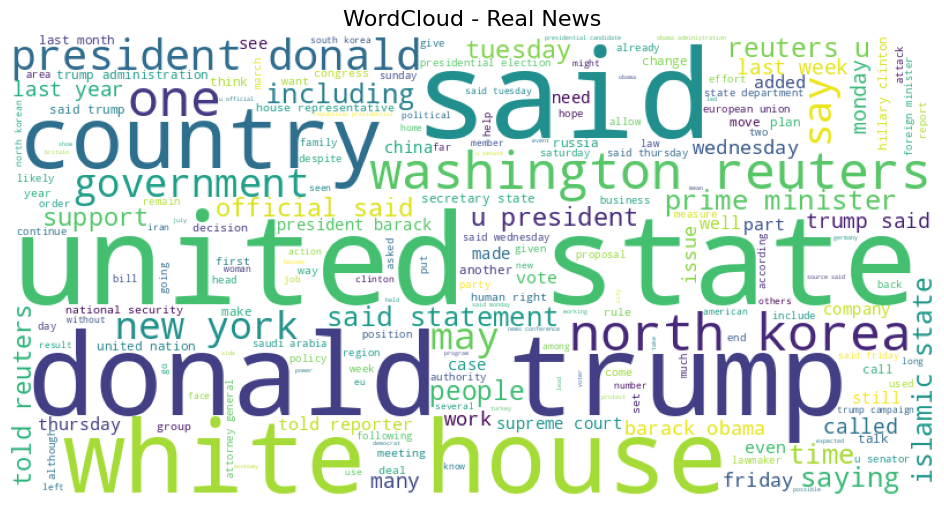

In [20]:
plt.figure(figsize=(12,6))
plt.title("WordCloud - Real News", fontsize=16)
plt.imshow(WordCloud(width=800, height=400, background_color="white").generate(real_text))
plt.axis("off")
plt.show()

### WordCloud for Fake News

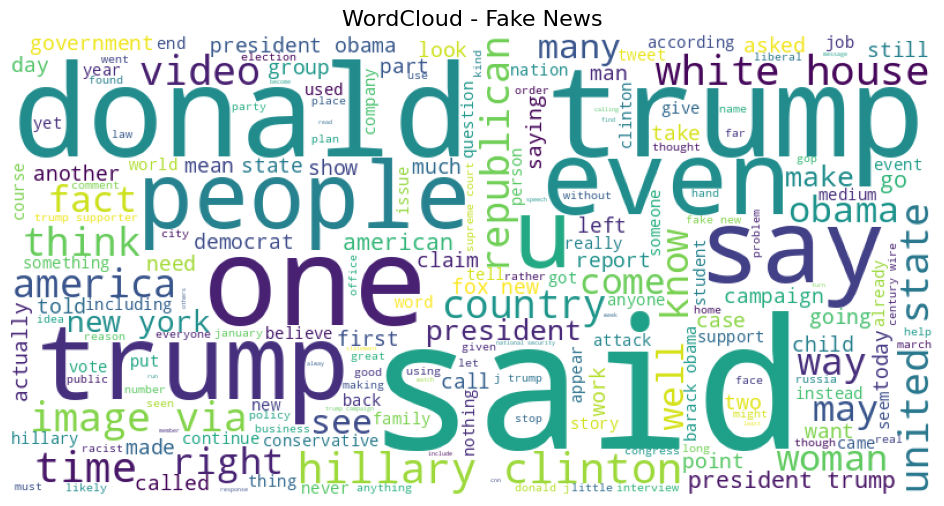

In [21]:
plt.figure(figsize=(12,6))
plt.title("WordCloud - Fake News", fontsize=16)
plt.imshow(WordCloud(width=800, height=400, background_color="white").generate(fake_text))
plt.axis("off")
plt.show()

## Distribution of News Length

### Add length column

In [22]:
df["text_length"] = df["clean_text"].apply(lambda x: len(x.split()))

### Plot distributions

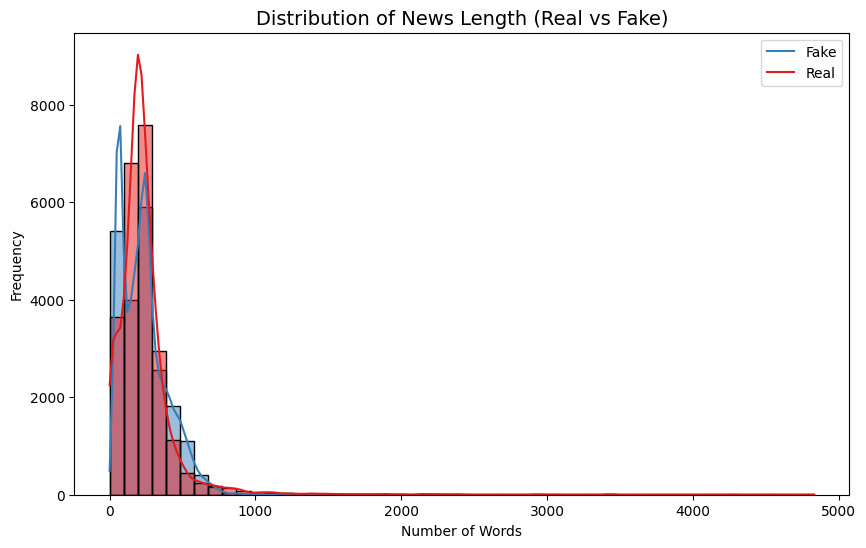

In [23]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="text_length", hue="label", bins=50, kde=True, palette="Set1")
plt.title("Distribution of News Length (Real vs Fake)", fontsize=14)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend(["Fake", "Real"])
plt.show()

# Feature Extraction

## TF-IDF Vectorization

### TF-IDF Vectorizer

In [24]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

### Fit-transform the clean text

In [25]:
X = tfidf.fit_transform(df["clean_text"])

### Target variable

In [26]:
y = df["label"]

In [27]:
print("TF-IDF shape:", X.shape)

TF-IDF shape: (44898, 5000)


## Train/Test Split

### Split the dataset (80% train, 20% test)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=537)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (35918, 5000)
Test size: (8980, 5000)


# ML Model Training & Evaluation

## Model Initialization

### Dictionary of ML models

In [29]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": LinearSVC()
}

## Model Training, Prediction, Evaluation

### List to store results

In [30]:
results = []

### Loop through each model

Training model: Logistic Regression

 Accuracy of Logistic Regression: 0.9895
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4677
        Real       0.99      0.99      0.99      4303

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



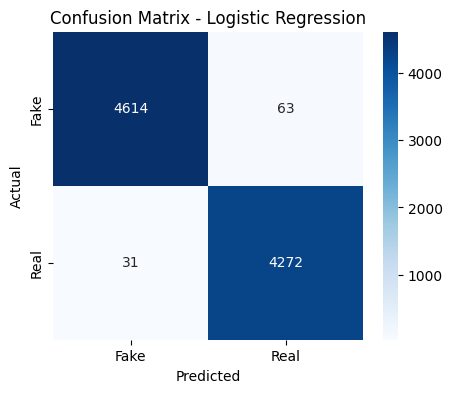

Training model: Naive Bayes

 Accuracy of Naive Bayes: 0.9404
              precision    recall  f1-score   support

        Fake       0.94      0.94      0.94      4677
        Real       0.94      0.94      0.94      4303

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



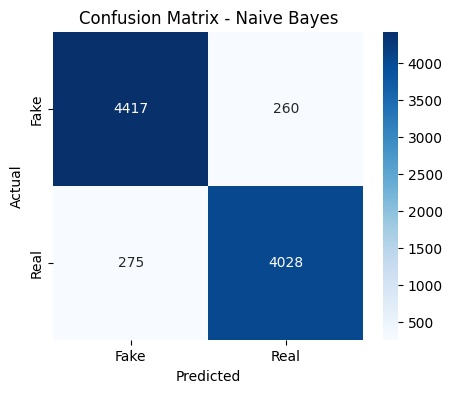

Training model: Random Forest

 Accuracy of Random Forest: 0.9976
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4677
        Real       1.00      1.00      1.00      4303

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



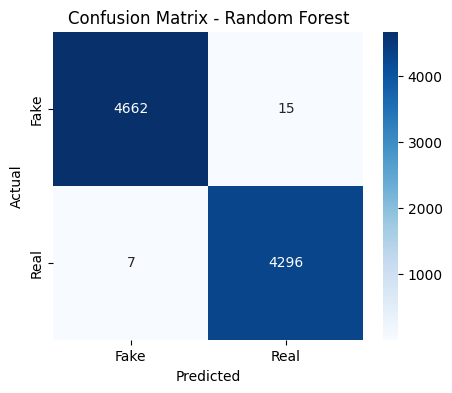

Training model: SVM

 Accuracy of SVM: 0.9951
              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      4677
        Real       0.99      1.00      0.99      4303

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



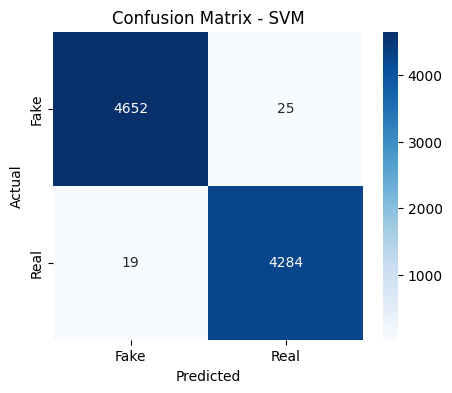

In [31]:
for name, model in models.items():
    print(f"Training model: {name}")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n Accuracy of {name}: {acc:.4f}")
    
    # Print classification report
    print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))
    
    # Store result
    results.append((name, acc))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## ROC Curve for Probabilistic Models

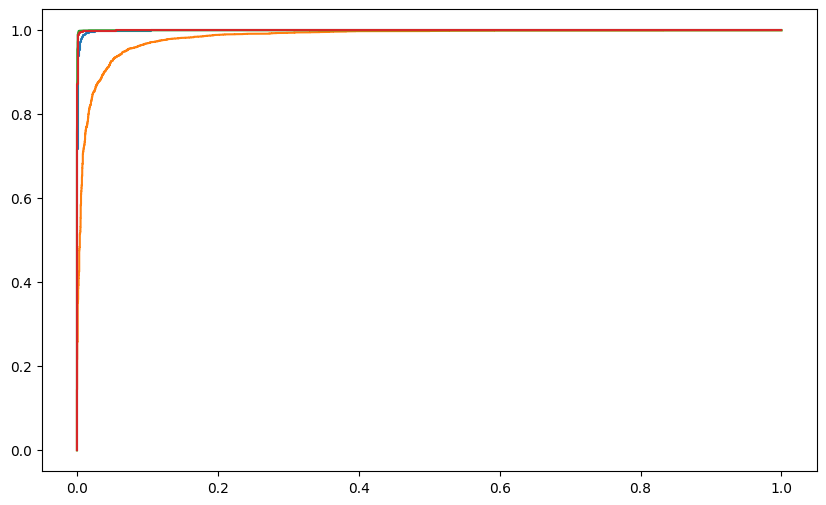

In [32]:
plt.figure(figsize=(10, 6))

for name, model in models.items():
    try:
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        else:
            continue
        
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")
    except:
        continue

### Baseline

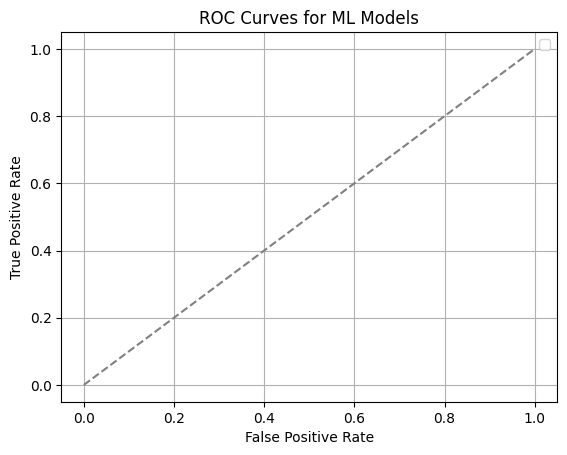

In [33]:
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for ML Models")
plt.legend()
plt.grid(True)
plt.show()

## Accuracy Comparison Chart

### Create dataframe for results

In [34]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

### Plot

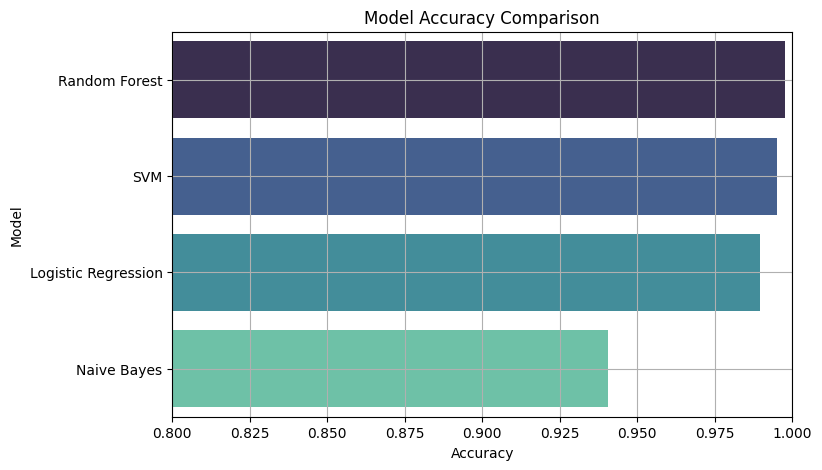

In [35]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="mako")
plt.title("Model Accuracy Comparison")
plt.xlim(0.8, 1.0)
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.grid(True)
plt.show()

### Display results

In [36]:
results_df

,Model,Accuracy
2,Random Forest,0.997550
3,SVM,0.995100
0,Logistic Regression,0.989532
1,Naive Bayes,0.940423


# Deep Learning Model with LSTM

## Text Tokenization & Padding

### Parameters

In [37]:
MAX_VOCAB = 10000       # max number of words in the vocabulary
MAX_LEN = 300           # max length of sequences (number of words per input)

### Tokenizer

In [38]:
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])

### Convert text to sequences

In [39]:
sequences = tokenizer.texts_to_sequences(df["clean_text"])

### Pad sequences to fixed length

In [40]:
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding="post", truncating="post")

### Labels

In [41]:
labels = df["label"].values

## Train-Test Split

### Split the padded sequences and labels

In [42]:
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=537)

## Define the LSTM Model

### Define the model

In [43]:
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # binary classification
])

2025-05-27 11:05:56.505406: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Compile the model

In [44]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model summary

In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [46]:
history = model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_test_dl, y_test_dl),
    epochs=5,
    batch_size=256,
    verbose=1
)

Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.6016 - loss: 0.6511 - val_accuracy: 0.5698 - val_loss: 0.6470
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.5591 - loss: 0.6546 - val_accuracy: 0.5581 - val_loss: 0.6532
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.5633 - loss: 0.6562 - val_accuracy: 0.5494 - val_loss: 0.6570
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.5945 - loss: 0.6466 - val_accuracy: 0.8712 - val_loss: 0.3765
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.8072 - loss: 0.4422 - val_accuracy: 0.8591 - val_loss: 0.4206


## Visualize Accuracy and Loss

### Plot accuracy

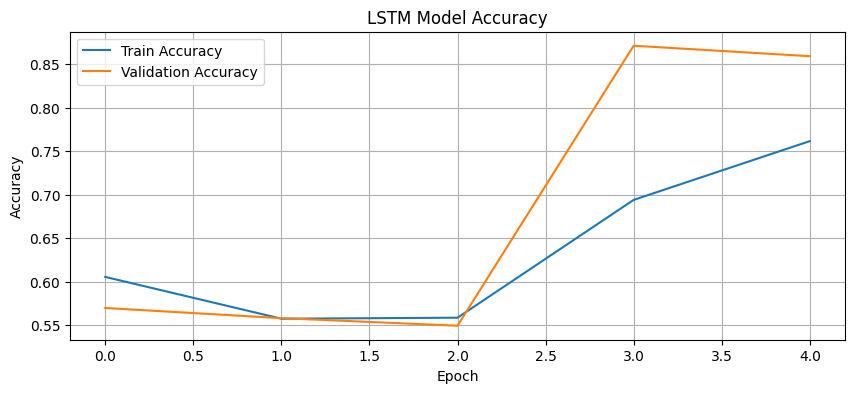

In [47]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("LSTM Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Plot loss

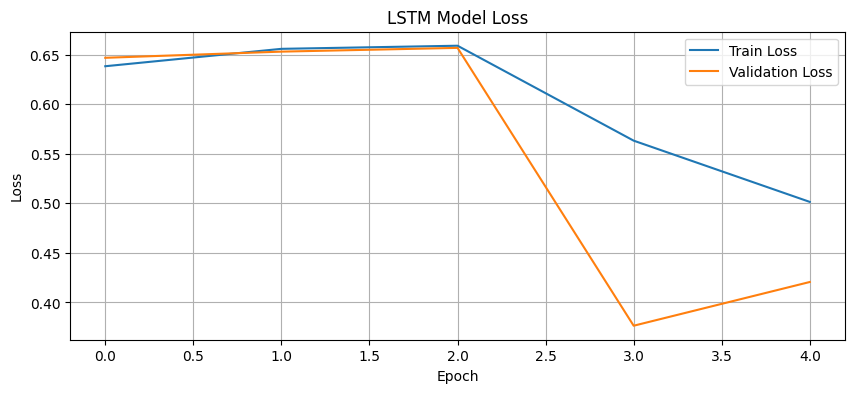

In [48]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("LSTM Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## Evaluate the Model on Test Data

### Evaluate performance

In [49]:
loss, accuracy = model.evaluate(X_test_dl, y_test_dl)
print(f"\nFinal Test Accuracy: {accuracy:.4f}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 35s 123ms/step - accuracy: 0.8554 - loss: 0.4264

Final Test Accuracy: 0.8591


# Predicting on New Inputs

## Prediction Function

In [50]:
def predict_news(text, model, tokenizer, max_len=300):

    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()

    def clean_input(t):
        t = t.lower()
        t = t.translate(str.maketrans('', '', string.punctuation))
        words = nltk.word_tokenize(t)
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]
        return " ".join(words)

    # Preprocess
    cleaned = clean_input(text)
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Prediction
    prob = model.predict(padded)[0][0]
    label = "REAL" if prob > 0.5 else "FAKE"
    confidence = prob if prob > 0.5 else 1 - prob

    print(f" Text: {text}")
    print(f" Prediction: {label} ({confidence:.2f} confidence)")

## Example Predictions

In [51]:
examples = [
    "The CDC approves a new vaccine that prevents aging by 40%.",
    "NASA's James Webb Telescope captures image of the first galaxies.",
    "Apple announces the iPhone 25 will be implanted into the brain.",
    "UN releases a global climate report showing record-breaking heat levels in 2024.",
    "Scientists confirm that drinking bleach can boost your immune system.",
    "The World Bank predicts economic recovery in developing countries by 2026.",
]

for i, example in enumerate(examples, 1):
    print(f"\n Example {i}")
    predict_news(example, model, tokenizer)


 Example 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
 Text: The CDC approves a new vaccine that prevents aging by 40%.
 Prediction: REAL (0.79 confidence)

 Example 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
 Text: NASA's James Webb Telescope captures image of the first galaxies.
 Prediction: FAKE (0.55 confidence)

 Example 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
 Text: Apple announces the iPhone 25 will be implanted into the brain.
 Prediction: REAL (0.79 confidence)

 Example 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
 Text: UN releases a global climate report showing record-breaking heat levels in 2024.
 Prediction: REAL (0.59 confidence)

 Example 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
 Text: Scientists confirm that drinking bleach can boost your immune system.
 Prediction: REAL (0.60 confidence)

 Example 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
 Text: The World Bank predicts economic recovery in developing countries by 2026.
 Prediction: REAL (0.61 confidence)


# Final Evaluation – ML vs DL Comparison

## Visual Comparison

### Add DL model result

In [52]:
loss, lstm_accuracy = model.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"LSTM Model Accuracy: {lstm_accuracy:.4f}")
lstm_result = pd.DataFrame([{"Model": "LSTM", "Accuracy": lstm_accuracy}])
results_df = pd.concat([results_df, lstm_result], ignore_index=True)

LSTM Model Accuracy: 0.8591


### Plot

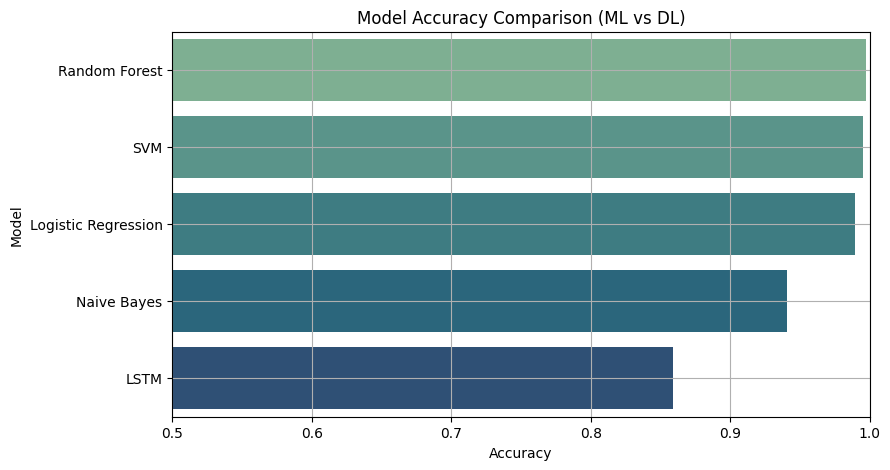

In [53]:
plt.figure(figsize=(9, 5))
sns.barplot(x="Accuracy", y="Model", data=results_df.sort_values(by="Accuracy", ascending=False), palette="crest")
plt.title("Model Accuracy Comparison (ML vs DL)")
plt.xlim(0.5, 1.00)
plt.grid(True)
plt.show()